# Forecasting
t<sub>0</sub> corresponds to the time at which the forecast is made (12:00 CET) for EPEX SPOT day-ahead auction.<br>

In [42]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from utils import tools, preprocessing, models, eval, plotting

In [43]:
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.2.3
Numpy version: 1.26.4
Tensorflow version: 2.17.1


In [44]:
config = tools.load_config('config.yaml')

In [45]:
# paths
data = 'pvod'
key = 'station00.csv'

# model params
model_name = 'tcn'
output_dim = 1 # in hours
batch_size = 16
learning_rate = 0.0004
epochs = 20
n_layers = 2
filters = 64
kernel_size = 2
units = 256
make_callbacks = False

# data params
freq = '1h'
lookback = 48 # in hours
horizon = 48 # in hours
# data split params
t_0 = 12 # epex spot auction time (12:00 CET)
scale_y = False
lag_in_col = False

# more params
evaluate_on_all_test_data = True
study_name = None#f'fl_d_{data}_m-{model_name}_out-{output_dim}_freq-{freq}'

In [46]:
# config related
config['data']['freq'] = freq
config['model']['name'] = model_name
config['model']['output_dim'] = output_dim
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon
config = tools.handle_freq(config=config)
freq = config['data']['freq']
output_dim = config['model']['output_dim']
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon

In [47]:
# read data
#df = preprocessing.preprocess_1b_trina(path=path,
#                                       freq=freq)
known, observed, static = preprocessing.get_features(data=data)
dfs = preprocessing.get_data(data=data, data_dir=config['data']['path'], freq=freq)
df = dfs[key]

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7248 entries, 2018-08-15 16:00:00 to 2019-06-13 15:00:00
Freq: h
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nwp_globalirrad    7224 non-null   float64
 1   nwp_directirrad    7224 non-null   float64
 2   nwp_temperature    7224 non-null   float64
 3   nwp_humidity       7224 non-null   float64
 4   nwp_windspeed      7224 non-null   float64
 5   nwp_winddirection  7224 non-null   float64
 6   nwp_pressure       7224 non-null   float64
 7   lmd_totalirrad     7224 non-null   float64
 8   lmd_diffuseirrad   7224 non-null   float64
 9   lmd_temperature    7224 non-null   float64
 10  lmd_pressure       7224 non-null   float64
 11  lmd_winddirection  7224 non-null   float64
 12  lmd_windspeed      7224 non-null   float64
 13  power              7224 non-null   float64
dtypes: float64(14)
memory usage: 849.4 KB


In [49]:
prepared_data, df = preprocessing.pipeline(data=df,
                                           config=config,
                                           known_cols=known,
                                           observed_cols=observed,
                                           static_cols=static)
X_train, y_train = prepared_data['X_train'], prepared_data['y_train'],
X_test, y_test = prepared_data['X_test'], prepared_data['y_test']
index_train = prepared_data['index_train']
index_test = prepared_data['index_test']
scaler_y = prepared_data['scalers']['y']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5385, 1, 14) (5385, 1) (1792, 1, 14) (1792, 1)


In [50]:
if study_name:
    hyperparameters = tools.load_hyperparams(study_name=study_name,
                                             config=config)
else:
    hyperparameters = {}
    hyperparameters['batch_size'] = batch_size
    hyperparameters['epochs'] = epochs
    hyperparameters['output_dim'] = output_dim
    hyperparameters['n_layers'] = n_layers
    hyperparameters['filters'] = filters
    hyperparameters['kernel_size'] = kernel_size
    hyperparameters['lr'] = learning_rate
    hyperparameters['units'] = units

config['model']['name'] = model_name

config['model']['feature_dim'] = tools.get_feature_dim(X_train)
model = models.get_model(config=config,
                         hyperparameters=hyperparameters)

In [51]:
model.summary()

Model: "tcn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 1, 14)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_tcn_1 (Conv1D)              │ (None, 1, 64)          │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_tcn_2 (Conv1D)              │ (None, 1, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,497 (72.25 KB)

 Trainable params: 18,497 (72.25 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
if make_callbacks:
    callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', save_best_only=True)]

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = hyperparameters['batch_size'],
    epochs = hyperparameters['epochs'],
    verbose = 'auto',
    callbacks = callbacks if make_callbacks else None,
    validation_data=(X_test, y_test),
    shuffle = False
)
if make_callbacks:
    model = keras.models.load_model('models/best.keras')
best_epoch = np.argmin(history.history['val_loss']) + 1

Epoch 1/20


337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - loss: 0.0108 - mae: 0.0692 - rmse: 0.1014 - val_loss: 0.0168 - val_mae: 0.0810 - val_rmse: 0.1297
Epoch 2/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.0051 - mae: 0.0476 - rmse: 0.0708 - val_loss: 0.0137 - val_mae: 0.0732 - val_rmse: 0.1169
Epoch 3/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 0.0044 - mae: 0.0415 - rmse: 0.0655 - val_loss: 0.0115 - val_mae: 0.0694 - val_rmse: 0.1075
Epoch 4/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 0.0040 - mae: 0.0399 - rmse: 0.0627 - val_loss: 0.0103 - val_mae: 0.0670 - val_rmse: 0.1016
Epoch 5/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 0.0038 - mae: 0.0394 - rmse: 0.0614 - val_loss: 0.0096 - val_mae: 0.0639 - val_rmse: 0.0982
Epoch 6/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 0.0036 - mae: 0.0381 - rmse: 0.0599 - val_loss: 0.0094 - val_mae: 0.0615 - val_rmse: 0.0969
Epoch 7/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 0.0035 - mae: 0.0370 - rm

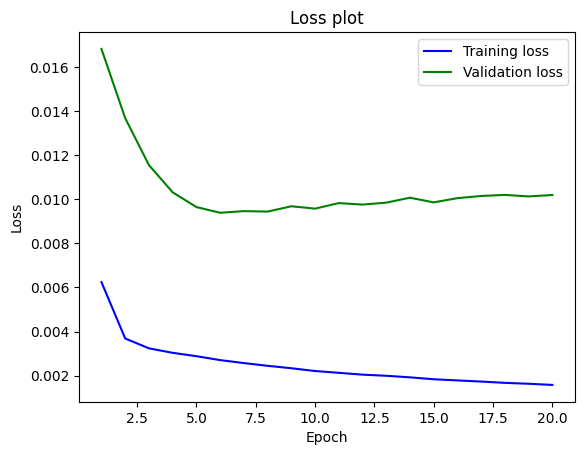

In [53]:
plotting.plot_training(history=history,
                       validation=True,
                       save_name=None)

In [54]:
y_true, y_pred = tools.get_y(X_test=X_test,
                             y_test=y_test,
                             output_dim=output_dim,
                             scaler_y=scaler_y,
                             model=model)
df_pred = tools.y_to_df(y=y_pred,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)
df_true = tools.y_to_df(y=y_true,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step


In [56]:
persistence = eval.benchmark_models(data=df,
                                     horizon=horizon,
                                     train_end=str(index_train[0]),
                                     test_start=str(index_test[0]),
                                     output_dim=output_dim,
                                     index_test=index_test,
                                     t_0=None if evaluate_on_all_test_data else t_0)

In [57]:
results = eval.evaluate_models(pred=df_pred,
                                true=df_true,
                                persistence=persistence)
results

,R^2,RMSE,MAE,Skill
Models,,,,
Main,0.811851,0.099061,0.053179,0.274066
Persistence,0.642967,0.136460,0.066388,0.000000
LinearRegression,-0.587197,0.287718,0.175002,-1.108440


R^2: 0.9671229933297218
RMSE: 0.049764632508486534
MAE: 0.03093055900637136


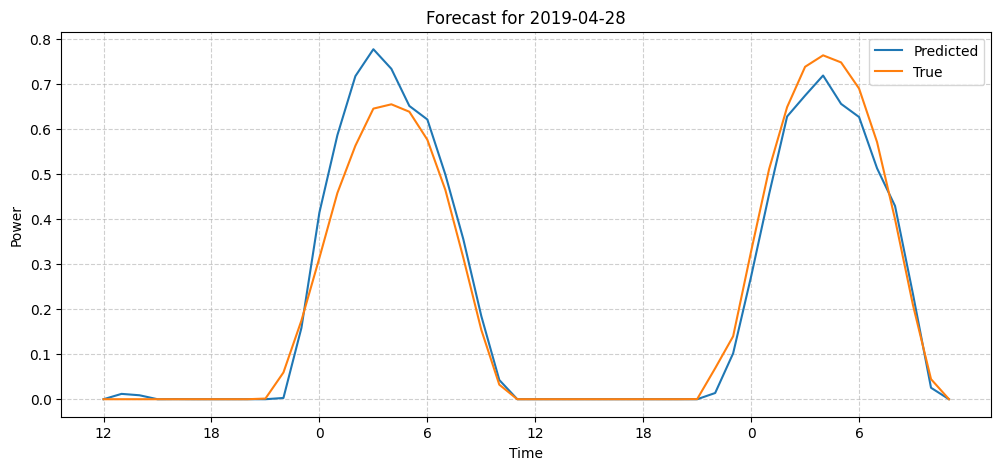

In [62]:
#date = '2018-06-06'
date = plotting.random_date(start_date=str(index_test[0].date()),
                            end_date=str(df.index[-1].date()))

plotting.plot_forecast(pred=df_pred,
                       true=df_true,
                       date=date,
                       horizon=horizon,
                       t_0=t_0,
                       figsize=(12,5),
                       print_metric=True,
                       grid=True)

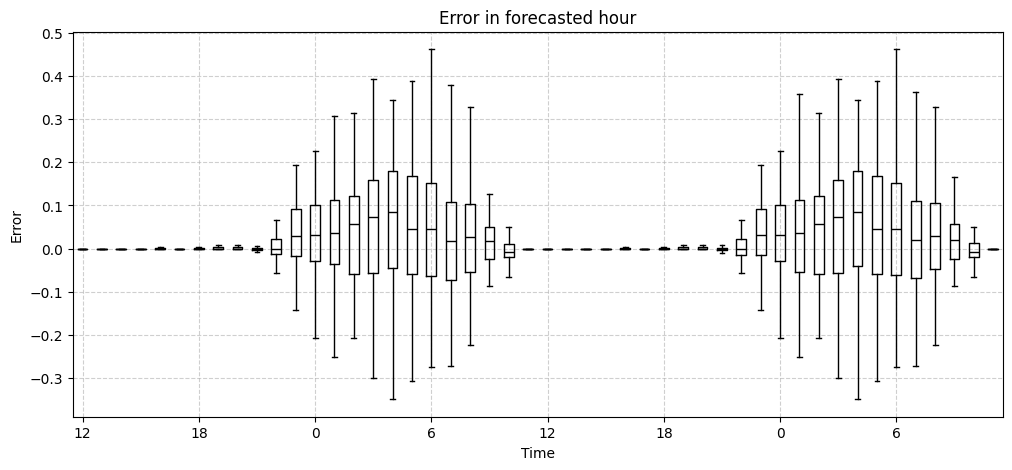

In [63]:
plotting.plot_boxplots(pred=df_pred,
                       true=df_true,
                       t_0=t_0,
                       horizon=horizon,
                       figsize=(12,5),
                       showfliers=False,
                       grid=True)

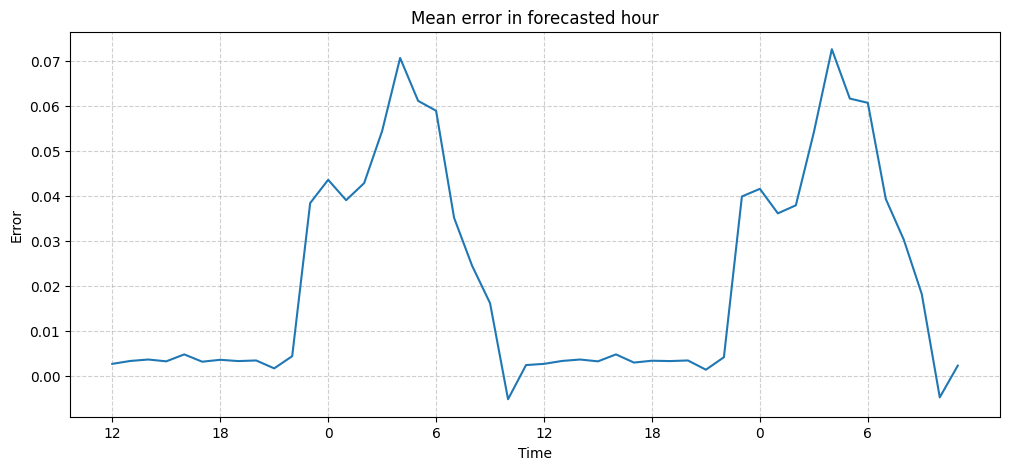

In [64]:
plotting.plot_error(pred=df_pred,
                    true=df_true,
                    t_0=t_0,
                    horizon=horizon,
                    figsize=(12,5),
                    grid=True)

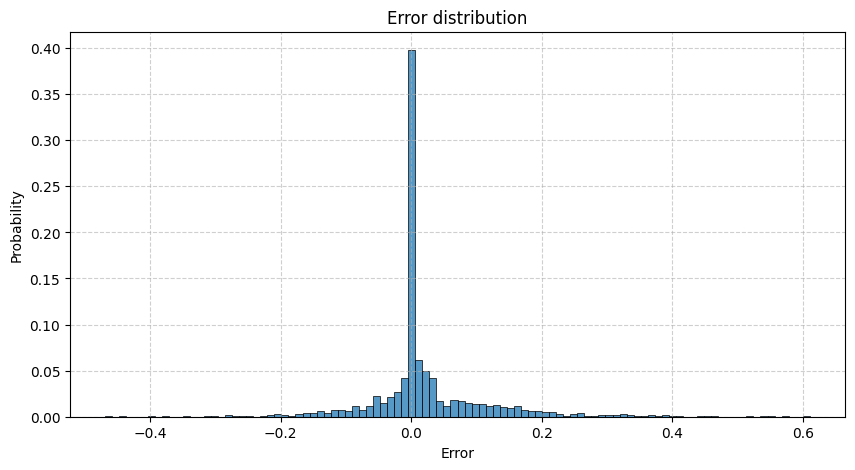

In [65]:
plotting.plot_error_distribution(pred=df_pred,
                                 true=df_true,
                                 figsize=(10,5),
                                 bins=100,
                                 t_0=t_0,
                                 grid=True)